# MFS demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [10]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.visibility.base import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, smooth_image, \
    calculate_image_frequency_moments, calculate_image_from_frequency_moments
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import  image_raster_iter
from arl.image.solvers import solve_image
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, \
    create_low_test_image_from_gleam, create_low_test_beam
from arl.imaging import *
from arl.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW configuration

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [11]:
config = 'full'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=5 * 2048
    padding = 1
    invert = invert_2d
    predict = predict_2d

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    padding = 2
    invert = invert_2d
    predict = predict_2d

    
oversampling = 32

nchan = 7
frequency = numpy.linspace(0.8e8, 1.2e8, nchan)
centre_frequency = numpy.array([numpy.average(frequency)])
channel_bandwidth=numpy.array(nchan * [frequency[1]-frequency[0]])
total_bandwidth = numpy.array([numpy.sum(channel_bandwidth)])

times = numpy.linspace(-3, +3, 5) * numpy.pi / 12.0
log.info('Observing times %s' % (times))
log.info("Observing frequencies %s Hz" % (frequency))
log.info("Channel bandwidths %s Hz" % (channel_bandwidth))
log.info("Centre frequency %s Hz" % (centre_frequency))
log.info("Cellsize = %.6f radians" % (cellsize))

Observing times [-0.78539816 -0.39269908  0.          0.39269908  0.78539816]
Observing times [-0.78539816 -0.39269908  0.          0.39269908  0.78539816]
Observing frequencies [  8.00000000e+07   8.66666667e+07   9.33333333e+07   1.00000000e+08
   1.06666667e+08   1.13333333e+08   1.20000000e+08] Hz
Observing frequencies [  8.00000000e+07   8.66666667e+07   9.33333333e+07   1.00000000e+08
   1.06666667e+08   1.13333333e+08   1.20000000e+08] Hz
Channel bandwidths [ 6666666.66666667  6666666.66666667  6666666.66666667  6666666.66666667
  6666666.66666667  6666666.66666667  6666666.66666667] Hz
Channel bandwidths [ 6666666.66666667  6666666.66666667  6666666.66666667  6666666.66666667
  6666666.66666667  6666666.66666667  6666666.66666667] Hz
Centre frequency [  1.00000000e+08] Hz
Centre frequency [  1.00000000e+08] Hz
Cellsize = 0.000010 radians
Cellsize = 0.000010 radians


In [12]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 4578560 rows, 0.478 GB
create_visibility: 4578560 rows, 0.478 GB


Plot the synthesized uv coverage

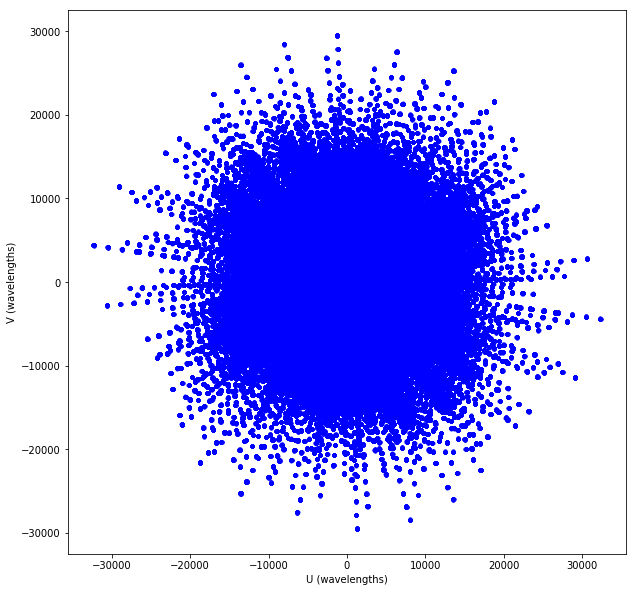

In [13]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [14]:
model_centrechannel = create_low_test_image_from_gleam(npixel=npixel, 
                                                       frequency=centre_frequency, 
                                                       channel_bandwidth=total_bandwidth, 
                                                       cellsize=cellsize, 
                                                       phasecentre=phasecentre)
export_image_to_fits(model_centrechannel, '%s/imaging-mfs-model_centre_channel.fits' % 
                     (results_dir))

create_low_test_image_from_gleam: 678 sources inside the image
create_low_test_image_from_gleam: 678 sources inside the image
create_low_test_image_from_gleam: Average flux per channel in image = 203.716
create_low_test_image_from_gleam: Average flux per channel in image = 203.716


In [15]:
model_multichannel = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency, 
                                                      channel_bandwidth=channel_bandwidth, 
                                                      cellsize=cellsize, 
                                                      phasecentre=phasecentre)

create_image_from_array: created float64 image of shape (7, 1, 10240, 10240), size 5.469 (GB)
create_image_from_array: created float64 image of shape (7, 1, 10240, 10240), size 5.469 (GB)
create_low_test_image_from_gleam: 678 sources inside the image
create_low_test_image_from_gleam: 678 sources inside the image
create_low_test_image_from_gleam: Average flux per channel in image = 207.344
create_low_test_image_from_gleam: Average flux per channel in image = 207.344


In [16]:
import time
start = time.time()
beam=create_low_test_beam(model_multichannel)
model_multichannel.data*=beam.data
print("Model * beam has %.3f Jy" % (numpy.sum(model_multichannel.data[0,0,:,:])))
cmodel = smooth_image(model_multichannel)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-mfs-cmodel.fits' % (results_dir))
beam = None
cmodel = None
stop = time.time()
print('beam time:', stop - start)

import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /home/yangrunkai/data/ska/arl_code/arl-new/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
import_image_from_fits: Max, min in /home/yangrunkai/data/ska/arl_code/arl-new/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_low_test_beam: primary beam is defined at 100.000 MHz
create_empty_image_like: created float64 image of shape (7, 1, 10240, 10240), size 5.469 (GB)
create_empty_image_like: created float64 image of shape (7, 1, 10240, 10240), size 5.469 (GB)


KeyboardInterrupt: 

In [ ]:
export_image_to_fits(model_multichannel, '%s/imaging-mfs-multi_channel.fits' % (results_dir))
moment_cube = calculate_image_frequency_moments(model_multichannel,nmoments=3)
export_image_to_fits(moment_cube, '%s/imaging-mfs-moment_cube.fits' % (results_dir))

In [ ]:
reconstructed_cube = calculate_image_from_frequency_moments(model_multichannel, moment_cube)
export_image_to_fits(reconstructed_cube, '%s/imaging-mfs-reconstructed_cube.fits' % 
                     (results_dir))

In [ ]:
vt.data['vis'] *= 0.0
vt = predict(vt, model_multichannel)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Weight the data

In [ ]:
vt, density, densitygrid = weight_visibility(vt, model_centrechannel)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

In [ ]:
dirty, sumwt = invert(vt, model_multichannel, padding=1)
show_image(dirty)
psf, sumwt = invert(vt, model_multichannel, dopsf=True, padding=1)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % 
      (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % 
      (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-mfs-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-mfs-psf.fits' % (results_dir))

In [ ]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, gain=0.7, algorithm='msmfsclean',
                scales=[0, 3, 10, 30], threshold=0.01, fractional_threshold=0.001, nmoments=3)
export_image_to_fits(comp, '%s/imaging-mfs-comp.fits' % (results_dir))
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(residual, '%s/imaging-mfs-residual.fits' % (results_dir))
export_image_to_fits(clean, '%s/imaging-mfs-clean.fits' % (results_dir))
show_image(clean)
plt.show()

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict(vtmodel, comp)

Now we will plot the original visibility and the residual visibility.

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', 
         label='Residual')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()